In [2]:
dataset_folder = "./speech_commands_v0.02"

In [3]:
import librosa
import numpy as np
import pandas as pd


def load_audio(file_path, sr=16000, duration=None):
    """Load audio file and convert to time series"""
    audio, sample_rate = librosa.load(file_path, sr=sr, duration=duration)
    return audio, sample_rate

def load_raw_audio(file_path, sr=16000, target_length=16000):
    """Prepare raw audio waveform for neural networks"""
    audio, sr = librosa.load(file_path, sr=sr)

    # Pad or truncate to fixed length
    if len(audio) < target_length:
        # Pad with zeros (center the audio)
        padding_length = target_length - len(audio)
        left_pad = padding_length // 2
        right_pad = padding_length - left_pad
        audio = np.pad(audio, (left_pad, right_pad))
    else:
        # Truncate
        audio = audio[:target_length]

    return audio, sr  # Shape for neural network input

In [4]:
def extract_mfcc(file_path, sr=16000, n_mfcc=16, n_mels=32, n_fft=512, hop_length=512):
    """Estrae gli MFCC da un file audio usando librosa"""
    # Carica il file audio
    audio, sample_rate = librosa.load(file_path, sr=sr)

    # Estrae gli MFCC
    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=sample_rate,
        n_mfcc=n_mfcc,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )

    return mfcc

def extract_mfcc_from_audio(audio, sample_rate=16000, n_mfcc=16, n_mels=32, n_fft=512, hop_length=256):

    # Estrae gli MFCC
    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=sample_rate,
        n_mfcc=n_mfcc,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )

    return mfcc

In [5]:
keywords = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
#keywords = ['yes']

In [6]:
test_files = []
validation_files = []

# Read test_list.txt
with open(f'{dataset_folder}/testing_list.txt', 'r') as f:
    test_files = [line.strip() for line in f.readlines()]

# Read validation_list.txt
with open(f'{dataset_folder}/validation_list.txt', 'r') as f:
    validation_files = [line.strip() for line in f.readlines()]

print(f"Test files: {len(test_files)}")
print(f"Validation files: {len(validation_files)}")

Test files: 11005
Validation files: 9981


In [7]:
import os
from sklearn.preprocessing import MinMaxScaler

def create_keyword_df(keywords, sr=16000, n_mfcc=16, n_mels=32, n_fft=512, hop_length=256):
    """Create a DataFrame with audio data for each keyword"""
    train = []
    test = []
    val = []
    data = []
    for keyword in keywords:
        print(f'Processing keyword: {keyword}')
        folder_path = f'{dataset_folder}/{keyword}'
        files = [f for f in os.listdir(folder_path)
         if os.path.isfile(os.path.join(folder_path, f))]

        for file in files:
            file_path = os.path.join(folder_path, file)
            file = f"{keyword}/{file}"
            if file.endswith('.wav'):
                audio, sample_rate = load_raw_audio(file_path, sr=sr)
                mfcc = extract_mfcc_from_audio(audio, sample_rate=sample_rate,  n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
                if file in test_files:
                    test.append({
                    'keyword': keyword,
                    'audio': mfcc.T
                })
                elif file in validation_files:
                    val.append({
                    'keyword': keyword,
                    'audio': mfcc.T
                })
                else:
                    train.append({
                    'keyword': keyword,
                    'audio': mfcc.T
                })
    
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    val = pd.DataFrame(val)

    
    # Collect all MFCC features to find global min/max
    all_mfcc = np.concatenate([mfcc.flatten() for mfcc in train['audio']])
    all_mfcc = np.concatenate([mfcc.flatten() for mfcc in test['audio']])
    all_mfcc = np.concatenate([mfcc.flatten() for mfcc in val['audio']])
    global_min = np.min(all_mfcc)
    global_max = np.max(all_mfcc)
    
    train['audio'] = 2 * (train['audio'] - global_min) / (global_max - global_min) - 1
    test['audio'] = 2 * (test['audio'] - global_min) / (global_max - global_min) - 1
    val['audio'] = 2 * (val['audio'] - global_min) / (global_max - global_min) - 1

    
    return train, test, val

In [25]:
n_mfcc = 13
n_mels = 32
n_fft = 512
hop_length = int(n_fft * 0.5)

train, test, val = create_keyword_df(keywords, sr=16000, n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Validation shape: {val.shape}")

Processing keyword: yes
Processing keyword: no
Processing keyword: up
Processing keyword: down
Processing keyword: left
Processing keyword: right
Processing keyword: on
Processing keyword: off
Processing keyword: stop
Processing keyword: go
Train shape: (30769, 2)
Test shape: (4074, 2)
Validation shape: (3703, 2)


In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train['keyword'] = label_encoder.fit_transform(train['keyword'])

test['keyword'] = label_encoder.transform(test['keyword'])
val['keyword'] = label_encoder.transform(val['keyword'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(label_mapping)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'up': 8, 'yes': 9}


In [27]:
import torch
from torch.utils.data import Dataset

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)


class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.features = data["audio"].values
        self.labels = data["keyword"].values
        self.transform = transform

        print(f"Dataset size: {len(self.features)} samples")
        print(f"Feature shape: {self.features[0].shape if len(self.features) > 0 else 'N/A'}")
        print(f"Label shape: {self.labels.shape if len(self.labels) > 0 else 'N/A'}")

    def __getitem__(self, index):
        features = self.features[index]
        labels = self.labels[index]
        sample = {'feature': torch.tensor(features, dtype=torch.float32), 'label': torch.tensor(labels, dtype=torch.long)}
        return sample

    def __len__(self):
        return len(self.features)

cpu


In [28]:
train_dataset = CustomDataset(train)
test_dataset = CustomDataset(test)
val_dataset = CustomDataset(val)

Dataset size: 30769 samples
Feature shape: (63, 13)
Label shape: (30769,)
Dataset size: 4074 samples
Feature shape: (63, 13)
Label shape: (4074,)
Dataset size: 3703 samples
Feature shape: (63, 13)
Label shape: (3703,)


In [62]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train loader size: {len(train_loader)}")
print(f"Test loader size: {len(test_loader)}")
print(f"Validation loader size: {len(val_loader)}")

Train loader size: 241
Test loader size: 32
Validation loader size: 29


In [63]:
i = 0
for data in train_loader:
  if  i == 10:
    inputs, labels = data['feature'].float(), data['label']
    time_steps = inputs.size(2)
    print(inputs.shape)
    #print(inputs)
    print(labels.shape)
    #print(labels)
    break
  i += 1

torch.Size([128, 63, 13])
torch.Size([128])


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_multilabel_confusion_matrix(y_true, y_pred, class_labels=None):
    """
    Plot a single confusion matrix for multilabel classification.

    Parameters:
    -----------
    y_true : array-like of shape (n_samples, n_classes)
        True binary labels in multilabel format
    y_pred : array-like of shape (n_samples, n_classes)
        Predicted binary labels in multilabel format
    class_labels : list of str, optional
        Names of the classes. If None, numeric labels are used.

    Returns:
    --------
    matplotlib figure with confusion matrix
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # For multilabel, convert to single-label format for confusion matrix
    # Use argmax to convert multilabel to multiclass if needed
    if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create labels if not provided
    n_classes = cm.shape[0]
    if class_labels is None:
        class_labels = [f'Class {i}' for i in range(n_classes)]

    # Create the plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)

    plt.title('Multilabel Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()

    return plt

In [65]:
from snntorch import surrogate

alpha = 0.5
beta  = 0.5
spike_grad = surrogate.fast_sigmoid(slope=20)

input_size =  n_mfcc
output_size = len(label_mapping)

In [66]:
import torch.nn as nn
import snntorch as snn
import torch.nn.functional as F

# Define Network
class LIF(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=128, output_size=output_size, threshold=0.01, verbose=False, output_type='spk', dropout=0.1):
        super().__init__()

        self.verbose = verbose
        self.output_type = output_type

        # Initialize layers (3 linear layers and 3 leaky layers)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

        self.dropout1 = nn.Dropout(p=dropout)

        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

    def forward(self, x):

        #print(f"Input shape: {x.shape}") # [32, 16, 32] [batch_size, input_features, time_steps]
        #x = x.permute(2, 0, 1)  # Change to [time_steps, batch_size, input_features]
        batch_size, time_steps, input_features= x.size()

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        mem1_rec = []
        mem2_rec = []
        spk1_rec = []
        spk2_rec = []

        for step in range(time_steps):

            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1 = self.dropout1(spk1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            mem1_rec.append(mem1)
            mem2_rec.append(mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)

        if self.output_type == 'mem':
            output = mem2_rec
        elif self.output_type == 'spk':
            output = spk2_rec

        mem1_rec = torch.stack(mem1_rec, dim=0)
        mem2_rec = torch.stack(mem2_rec, dim=0)
        spk1_rec = torch.stack(spk1_rec, dim=0)
        spk2_rec = torch.stack(spk2_rec, dim=0)

        if self.verbose:
            print(f"Mem1: {torch.max(mem1_rec)}")
            print(f"Mem2: {torch.max(mem2_rec)}")
            print(f"Spk1: {torch.sum(spk1_rec)}")
            if self.output_type == 'spk':
                print(f"Spk2: {spk2_rec}")
            else:
                print(f"Spk2: {torch.sum(spk2_rec)}")

        return torch.stack(output, dim=0)

In [67]:
import torch.nn as nn
import snntorch as snn
import torch.nn.functional as F

# Define Network
class LIF2(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=128, output_size=output_size, threshold=0.01, verbose=False, output_type='spk', dropout=0.1):
        super().__init__()

        self.verbose = verbose
        self.output_type = output_type

        # Initialize layers (3 linear layers and 3 leaky layers)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

        self.dropout1 = nn.Dropout(p=dropout)

        hidden_size2 = int(hidden_size / 2)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

        self.dropout2 = nn.Dropout(p=dropout)

        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

    def forward(self, x):

        #x = x.permute(2, 0, 1)  # Change to [time_steps, batch_size, input_features]
        batch_size, time_steps, input_features= x.size()

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        mem1_rec = []
        mem2_rec = []
        mem3_rec = []
        spk1_rec = []
        spk2_rec = []
        spk3_rec = []

        for step in range(time_steps):

            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1 = self.dropout1(spk1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2 = self.dropout2(spk2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            mem1_rec.append(mem1)
            mem2_rec.append(mem2)
            mem3_rec.append(mem3)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            spk3_rec.append(spk3)

        if self.output_type == 'mem':
            output = mem3_rec
        elif self.output_type == 'spk':
            output = spk3_rec

        mem1_rec = torch.stack(mem1_rec, dim=0)
        mem2_rec = torch.stack(mem2_rec, dim=0)
        mem3_rec = torch.stack(mem3_rec, dim=0)
        spk1_rec = torch.stack(spk1_rec, dim=0)
        spk2_rec = torch.stack(spk2_rec, dim=0)
        spk3_rec = torch.stack(spk3_rec, dim=0)

        if self.verbose:
            print(f"Mem1: {torch.max(mem1_rec)}")
            print(f"Spk1: {torch.sum(spk1_rec)}")
            print(f"Mem2: {torch.max(mem2_rec)}")
            print(f"Spk2: {torch.sum(spk2_rec)}")
            if self.output_type == 'spk':
                print(f"Spk3: {spk3_rec}")
            else:
                print(f"Spk3: {torch.sum(spk3_rec)}")
        
        return torch.stack(output, dim=0)

In [68]:
import torch.nn as nn
import snntorch as snn
import torch.nn.functional as F

# Define Network
class LIF3(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=128, output_size=output_size, threshold=0.01, verbose=False, output_type='spk', dropout=0.1):
        super().__init__()

        self.verbose = verbose
        self.output_type = output_type

        # Initialize layers (3 linear layers and 3 leaky layers)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

        self.dropout1 = nn.Dropout(p=dropout)

        hidden_size2 = int(hidden_size / 2)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

        self.dropout2 = nn.Dropout(p=dropout)

        hidden_size3 = int(hidden_size2 / 2)

        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

        self.dropout3 = nn.Dropout(p=dropout)

        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

    def forward(self, x):

        #x = x.permute(2, 0, 1)  # Change to [time_steps, batch_size, input_features]
        batch_size, time_steps, input_features= x.size()

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        mem1_rec = []
        mem2_rec = []
        mem3_rec = []
        mem4_rec = []
        spk1_rec = []
        spk2_rec = []
        spk3_rec = []
        spk4_rec = []

        for step in range(time_steps):

            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1 = self.dropout1(spk1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2 = self.dropout2(spk2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3 = self.dropout3(spk3)

            cur4 = self.fc4(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)

            mem1_rec.append(mem1)
            mem2_rec.append(mem2)
            mem3_rec.append(mem3)
            mem4_rec.append(mem4)

            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            spk3_rec.append(spk3)
            spk4_rec.append(spk4)

        if self.output_type == 'mem':
            output = mem4_rec
        elif self.output_type == 'spk':
            output = spk4_rec

        mem1_rec = torch.stack(mem1_rec, dim=0)
        mem2_rec = torch.stack(mem2_rec, dim=0)
        mem3_rec = torch.stack(mem3_rec, dim=0)
        mem4_rec = torch.stack(mem4_rec, dim=0)
        
        spk1_rec = torch.stack(spk1_rec, dim=0)
        spk2_rec = torch.stack(spk2_rec, dim=0)
        spk3_rec = torch.stack(spk3_rec, dim=0)
        spk4_rec = torch.stack(spk4_rec, dim=0)

        if self.verbose:
            print(f"Mem1: {torch.max(mem1_rec)}")
            print(f"Spk1: {torch.sum(spk1_rec)}")
            print(f"Mem2: {torch.max(mem2_rec)}")
            print(f"Spk2: {torch.sum(spk2_rec)}")
            print(f"Mem3: {torch.max(mem3_rec)}")
            print(f"Spk3: {torch.sum(spk3_rec)}")
            if self.output_type == 'spk':
                print(f"Spk4: {spk4_rec}")
            else:
                print(f"Spk4: {torch.sum(spk4_rec)}")
        
        return torch.stack(output, dim=0)

In [69]:
import torch.nn as nn
import snntorch as snn
import torch.nn.functional as F

# Define Network
class LIF4(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=128, output_size=output_size, threshold=0.01, verbose=False, output_type='spk', dropout=0.1):
        super().__init__()

        self.verbose = verbose
        self.output_type = output_type

        # Initialize layers (3 linear layers and 3 leaky layers)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

        self.dropout1 = nn.Dropout(p=dropout)

        hidden_size2 = int(hidden_size / 2)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

        self.dropout2 = nn.Dropout(p=dropout)

        hidden_size3 = int(hidden_size2 / 2)

        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

        self.dropout3 = nn.Dropout(p=dropout)

        hidden_size4 = int(hidden_size3 / 2)

        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

        self.dropout4 = nn.Dropout(p=dropout)

        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.lif5 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)



    def forward(self, x):

        #x = x.permute(2, 0, 1)  # Change to [time_steps, batch_size, input_features]
        batch_size, time_steps, input_features= x.size()

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        mem1_rec = []
        mem2_rec = []
        mem3_rec = []
        mem4_rec = []
        mem5_rec = []
        spk1_rec = []
        spk2_rec = []
        spk3_rec = []
        spk4_rec = []
        spk5_rec = []

        for step in range(time_steps):

            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1 = self.dropout1(spk1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2 = self.dropout2(spk2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3 = self.dropout3(spk3)

            cur4 = self.fc4(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)
            spk4 = self.dropout4(spk4)

            cur5 = self.fc5(spk4)
            spk5, mem5 = self.lif5(cur5, mem5)

            mem1_rec.append(mem1)
            mem2_rec.append(mem2)
            mem3_rec.append(mem3)
            mem4_rec.append(mem4)
            mem5_rec.append(mem5)

            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            spk3_rec.append(spk3)
            spk4_rec.append(spk4)
            spk5_rec.append(spk5)

        if self.output_type == 'mem':
            output = mem5_rec
        elif self.output_type == 'spk':
            output = spk5_rec

        mem1_rec = torch.stack(mem1_rec, dim=0)
        mem2_rec = torch.stack(mem2_rec, dim=0)
        mem3_rec = torch.stack(mem3_rec, dim=0)
        mem4_rec = torch.stack(mem4_rec, dim=0)
        mem5_rec = torch.stack(mem5_rec, dim=0)
        
        spk1_rec = torch.stack(spk1_rec, dim=0)
        spk2_rec = torch.stack(spk2_rec, dim=0)
        spk3_rec = torch.stack(spk3_rec, dim=0)
        spk4_rec = torch.stack(spk4_rec, dim=0)
        spk5_rec = torch.stack(spk5_rec, dim=0)

        if self.verbose:
            print(f"Mem1: {torch.max(mem1_rec)}")
            print(f"Spk1: {torch.sum(spk1_rec)}")
            print(f"Mem2: {torch.max(mem2_rec)}")
            print(f"Spk2: {torch.sum(spk2_rec)}")
            print(f"Mem3: {torch.max(mem3_rec)}")
            print(f"Spk3: {torch.sum(spk3_rec)}")
            print(f"Mem4: {torch.max(mem4_rec)}")
            print(f"Spk4: {torch.sum(spk4_rec)}")
            if self.output_type == 'spk':
                print(f"Spk5: {spk5_rec}")
            else:
                print(f"Spk5: {torch.sum(spk5_rec)}")
        
        return torch.stack(output, dim=0)

In [70]:
import torch.nn as nn
import snntorch as snn
import torch.nn.functional as F

# Define Network
class LIF1_2(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=128, output_size=output_size, threshold=0.01, verbose=False, output_type='spk', dropout=0.1):
        super().__init__()

        self.verbose = verbose
        self.output_type = output_type

        hidden_size2 = int(hidden_size / 2)

        self.fc1 = nn.Linear(input_size, hidden_size2)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)
        self.dropout1 = nn.Dropout(p=dropout)

        self.fc2 = nn.Linear(hidden_size2, hidden_size)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)
        self.dropout2 = nn.Dropout(p=dropout)

        self.fc3 = nn.Linear(hidden_size, hidden_size2)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)
        self.dropout3 = nn.Dropout(p=dropout)

        self.fc4 = nn.Linear(hidden_size2, output_size)
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, learn_beta=True, learn_threshold=True)

    def forward(self, x):

        #x = x.permute(2, 0, 1)  # Change to [time_steps, batch_size, input_features]
        batch_size, time_steps, input_features= x.size()

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        mem1_rec = []
        mem2_rec = []
        mem3_rec = []
        mem4_rec = []
        spk1_rec = []
        spk2_rec = []
        spk3_rec = []
        spk4_rec = []

        for step in range(time_steps):

            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1 = self.dropout1(spk1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2 = self.dropout2(spk2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3 = self.dropout3(spk3)

            cur4 = self.fc4(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)

            mem1_rec.append(mem1)
            mem2_rec.append(mem2)
            mem3_rec.append(mem3)
            mem4_rec.append(mem4)

            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            spk3_rec.append(spk3)
            spk4_rec.append(spk4)

        if self.output_type == 'mem':
            output = mem4_rec
        elif self.output_type == 'spk':
            output = spk4_rec

        mem1_rec = torch.stack(mem1_rec, dim=0)
        mem2_rec = torch.stack(mem2_rec, dim=0)
        mem3_rec = torch.stack(mem3_rec, dim=0)
        mem4_rec = torch.stack(mem4_rec, dim=0)
        
        spk1_rec = torch.stack(spk1_rec, dim=0)
        spk2_rec = torch.stack(spk2_rec, dim=0)
        spk3_rec = torch.stack(spk3_rec, dim=0)
        spk4_rec = torch.stack(spk4_rec, dim=0)

        if self.verbose:
            print(f"Mem1: {torch.max(mem1_rec)}")
            print(f"Spk1: {torch.sum(spk1_rec)}")
            print(f"Mem2: {torch.max(mem2_rec)}")
            print(f"Spk2: {torch.sum(spk2_rec)}")
            print(f"Mem3: {torch.max(mem3_rec)}")
            print(f"Spk3: {torch.sum(spk3_rec)}")
            print(f"Mem4: {torch.max(mem4_rec)}")
            print(f"Spk4: {torch.sum(spk4_rec)}")
        
        return torch.stack(output, dim=0)

In [85]:
model_type = 'LIF1-2'  # 'LIF', 'LIF2', 'LIF3', 'LIF4', 'LIF1_2'
output_type = 'spk' # 'spk', 'mem'
hidden_size = 512
verbose = False

if model_type == 'LIF':
    model = LIF(verbose=verbose, hidden_size=hidden_size, output_type=output_type,).to(device)
if model_type == 'LIF2':
    model = LIF2(verbose=verbose, hidden_size=hidden_size, output_type=output_type,).to(device)
if model_type == 'LIF3':
    model = LIF3(verbose=verbose, hidden_size=hidden_size, output_type=output_type,).to(device)
if model_type == 'LIF4':
    model = LIF4(verbose=verbose, hidden_size=hidden_size, output_type=output_type,).to(device)
if model_type == 'LIF1-2':
    model = LIF1_2(verbose=verbose, hidden_size=hidden_size, output_type=output_type,).to(device)

model.load_state_dict(torch.load(f'./models/{model_type}_{hidden_size}_{output_type}_{n_mfcc}_{n_fft}_{hop_length}.pth', weights_only=True))

total_params = sum(p.numel() for p in model.parameters())
param_size = sum(p.numel() * p.element_size() for p in model.parameters())
model_size_mb = param_size / (1024 * 1024)
print(f"Model loaded: {model_type}_{hidden_size}_{output_type}")
print(f"Total parameters: {total_params:,}")
print(f"Model size: {model_size_mb:.2f} MB")

Model loaded: LIF1-2_512_spk
Total parameters: 269,074
Model size: 1.03 MB


Model: LIF1-2_512_spk
Test accuracy: 89.27% - [3637/4074]


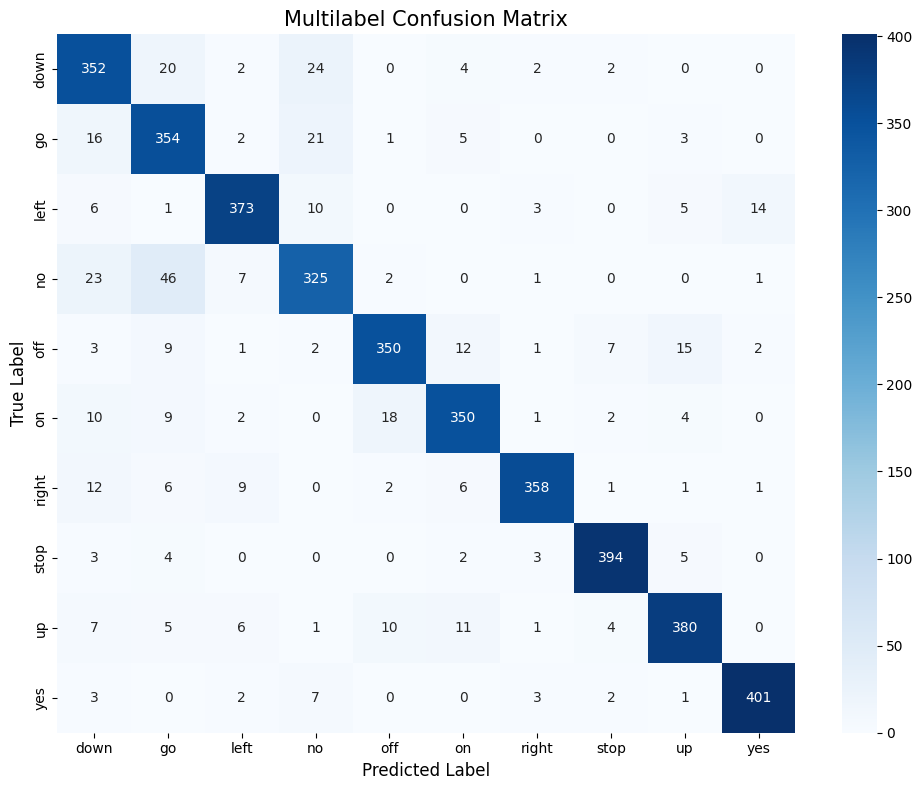

In [81]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []
    for data in test_loader:
        inputs, labels = data['feature'].float().to(device), data['label'].to(device)
        
        outputs = model(inputs)

        if output_type == 'spk':
            outputs = torch.sum(outputs, dim=0)
        else:
            outputs, _ = torch.max(outputs, dim=0)
        
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total if total > 0 else 0.0

cm = multilabel_confusion_matrix(all_labels, all_predicted)

print(f"Model: {model_type}_{hidden_size}_{output_type}")
print(f'Test accuracy: {accuracy:.2f}% - [{correct}/{total}]')

plot_multilabel_confusion_matrix(all_labels, all_predicted, class_labels=label_encoder.classes_).show()
plt.show()

In [82]:
from torchsummary import summary

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           3,584
             Leaky-2     [[-1, 256], [-1, 256]]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 512]         131,584
             Leaky-5     [[-1, 512], [-1, 512]]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
             Leaky-8     [[-1, 256], [-1, 256]]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
            Leaky-11       [[-1, 10], [-1, 10]]               0
Total params: 269,066
Trainable params: 269,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [83]:
from torchinfo import summary

summary(model, input_size=(batch_size, time_steps, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
LIF1_2                                   [13, 128, 10]             --
├─Linear: 1-1                            [128, 256]                3,584
├─Leaky: 1-2                             [128, 256]                2
├─Dropout: 1-3                           [128, 256]                --
├─Linear: 1-4                            [128, 512]                131,584
├─Leaky: 1-5                             [128, 512]                2
├─Dropout: 1-6                           [128, 512]                --
├─Linear: 1-7                            [128, 256]                131,328
├─Leaky: 1-8                             [128, 256]                2
├─Dropout: 1-9                           [128, 256]                --
├─Linear: 1-10                           [128, 10]                 2,570
├─Leaky: 1-11                            [128, 10]                 2
├─Linear: 1-12                           [128, 256]                (recur